## Exploratory Data Analysis

### Import Packages

In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing

### Read in Data

In [3]:
df = pd.read_csv('../data/Smaller Dataset - Data Wrangling.csv', index_col = 0, parse_dates = True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7255968 entries, 2015-09-05 13:30:00 to 2020-12-27 12:13:00
Data columns (total 8 columns):
 #   Column        Dtype  
---  ------        -----  
 0   ID            int64  
 1   IUCR          object 
 2   Primary Type  object 
 3   Description   object 
 4   Arrest        bool   
 5   Domestic      bool   
 6   Latitude      float64
 7   Longitude     float64
dtypes: bool(2), float64(2), int64(1), object(3)
memory usage: 401.4+ MB


In [5]:
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [6]:
df.index.to_series().min()

Timestamp('2001-01-01 00:00:00')

In [7]:
df.index.to_series().max()

Timestamp('2020-12-27 23:59:00')

In [8]:
# This is how many crimes resulted in arrest
df[df['Arrest']]['Arrest'].count()

1970069

In [9]:
# This is how many crimes were domestic
df[df['Domestic']]['Domestic'].count()

974228

### Group Data 

In [10]:
df.head()

,ID,IUCR,Primary Type,Description,Arrest,Domestic,Latitude,Longitude
Date,,,,,,,,
2015-09-05 13:30:00,10224738,0486,BATTERY,DOMESTIC BATTERY SIMPLE,False,True,41.815117,-87.670000
2015-09-04 11:30:00,10224739,0870,THEFT,POCKET-PICKING,False,False,41.895080,-87.765400
2018-09-01 00:01:00,11646166,0810,THEFT,OVER $500,False,True,NaN,NaN
2015-09-05 12:45:00,10224740,2023,NARCOTICS,POSS: HEROIN(BRN/TAN),True,False,41.937406,-87.716650
2015-09-05 13:00:00,10224741,0560,ASSAULT,SIMPLE,False,True,41.881903,-87.755121


#### First group by day and primary type

In [11]:
allcrimes_byday = df[['ID','Primary Type']].groupby(by=[df.index.date,'Primary Type']).count().rename(columns={'ID':'Count'})

In [12]:
allcrimes_byday = allcrimes_byday.reset_index().rename(columns={'level_0':'Date'}).set_index('Date')

In [13]:
allcrimes_byday.head()

,Primary Type,Count
Date,,
2001-01-01,ASSAULT,70
2001-01-01,BATTERY,296
2001-01-01,BURGLARY,66
2001-01-01,CRIM SEXUAL ASSAULT,38
2001-01-01,CRIMINAL DAMAGE,233


In [14]:
# Now pivot this data so we have a column for each type of crime
allcrimes_byday = allcrimes_byday.pivot(columns='Primary Type',values='Count')

In [15]:
# Replace missing values with 0's
allcrimes_byday = allcrimes_byday.fillna(0)

In [16]:
# Convert floats to ints
allcrimes_byday[list(allcrimes_byday.columns)] = allcrimes_byday[list(allcrimes_byday.columns)].astype(int)

In [17]:
allcrimes_byday.head()

Primary Type,ARSON,ASSAULT,BATTERY,BURGLARY,CONCEALED CARRY LICENSE VIOLATION,CRIM SEXUAL ASSAULT,CRIMINAL DAMAGE,CRIMINAL SEXUAL ASSAULT,CRIMINAL TRESPASS,DECEPTIVE PRACTICE,...,OTHER OFFENSE,PROSTITUTION,PUBLIC INDECENCY,PUBLIC PEACE VIOLATION,RITUALISM,ROBBERY,SEX OFFENSE,STALKING,THEFT,WEAPONS VIOLATION
Date,,,,,,,,,,,,,,,,,,,,,
2001-01-01,0,70,296,66,0,38,233,2,29,92,...,167,5,0,5,0,41,65,1,413,32
2001-01-02,0,66,143,68,0,2,118,0,35,78,...,101,11,0,2,0,35,4,0,221,9
2001-01-03,1,79,165,57,0,7,136,0,35,49,...,96,16,0,7,0,51,5,1,226,7
2001-01-04,1,57,173,55,0,2,133,0,29,42,...,96,19,0,3,0,55,1,0,243,9
2001-01-05,3,68,178,55,0,6,142,0,29,53,...,90,16,0,5,0,55,2,0,265,6


In [18]:
allcrimes_byday.shape

(7301, 36)

#### Add total crimes column

In [20]:
allcrimes_byday['Total Crimes'] = allcrimes_byday.sum(axis=1)

In [21]:
allcrimes_byday.shape

(7301, 37)

#### Group by day counting arrests and domestics

In [22]:
arrests_domestics = df[['Arrest','Domestic']].groupby(by=[df.index.date]).sum()

In [23]:
arrests_domestics[['Arrest','Domestic']] = arrests_domestics[['Arrest','Domestic']].astype('int')

In [24]:
arrests_domestics.head()

,Arrest,Domestic
2001-01-01,399,285
2001-01-02,383,146
2001-01-03,343,162
2001-01-04,377,131
2001-01-05,415,159


In [25]:
arrests_domestics.shape

(7301, 2)

#### Merge these two dataframes

In [26]:
allcrimes_byday = allcrimes_byday.join(arrests_domestics)

In [27]:
allcrimes_byday.shape

(7301, 39)

#### Convert index back to datetime and set frequency

In [28]:
allcrimes_byday.index = pd.to_datetime(allcrimes_byday.index)

In [29]:
allcrimes_byday.index.freq = 'd'

In [30]:
allcrimes_byday.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7301 entries, 2001-01-01 to 2020-12-27
Freq: D
Data columns (total 39 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   ARSON                              7301 non-null   int64
 1   ASSAULT                            7301 non-null   int64
 2   BATTERY                            7301 non-null   int64
 3   BURGLARY                           7301 non-null   int64
 4   CONCEALED CARRY LICENSE VIOLATION  7301 non-null   int64
 5   CRIM SEXUAL ASSAULT                7301 non-null   int64
 6   CRIMINAL DAMAGE                    7301 non-null   int64
 7   CRIMINAL SEXUAL ASSAULT            7301 non-null   int64
 8   CRIMINAL TRESPASS                  7301 non-null   int64
 9   DECEPTIVE PRACTICE                 7301 non-null   int64
 10  DOMESTIC VIOLENCE                  7301 non-null   int64
 11  GAMBLING                           7301 non-null   int64

## Data Visualization

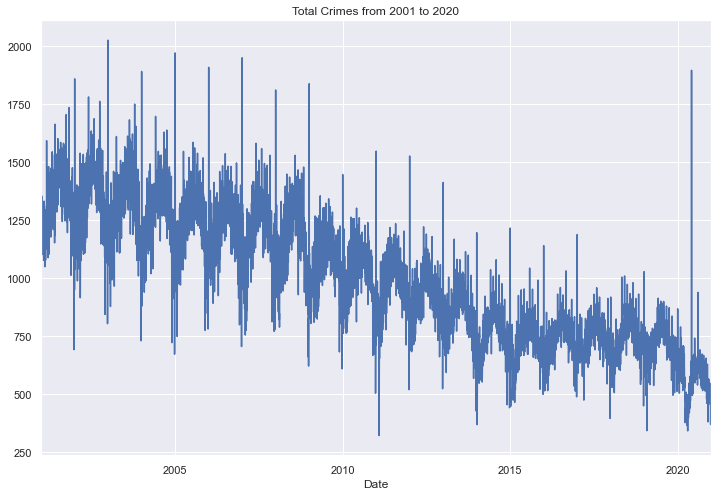

In [31]:
allcrimes_byday['Total Crimes'].plot(figsize=(12,8))
plt.title('Total Crimes from 2001 to 2020');

We can see from the plot that there is strong annual seasonality as well as a downward trend.  The trend does not appear to be exponential (although it's not quite linear either) and so we'll try both an additive model and multiplicative model for our smoothing algorithm.  In addition there seem to be large spikes on a yearly basis.  We also see a spike this past year, presumably during the time of the riots in the summer.  Let's try to to decompose this and see what we've got. 

### Seasonal Decomposition

In [112]:
decomp = seasonal_decompose(allcrimes_byday['Total Crimes'], period=365, model = 'add')

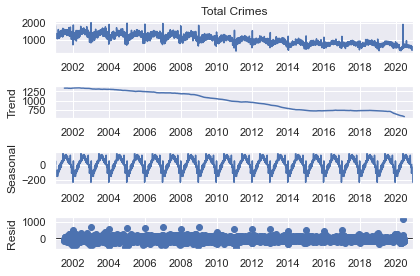

In [113]:
decomp.plot();

We can see the strong annual seasonal component. Let's try multiplicative.  

In [114]:
decomp = seasonal_decompose(allcrimes_byday['Total Crimes'], period=365, model = 'mul')

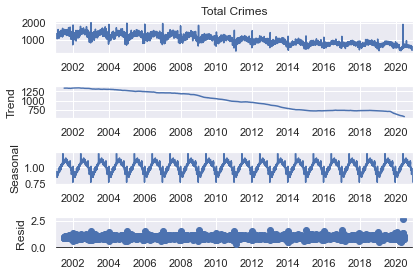

In [115]:
decomp.plot();

Interesting.  The multiplicative model tends to capture the yearly spikes as part of the seasonal component, whereas the additive model didn't, and had a much larger residual.  For this reason, it probably makes sense to use a multiplicative model, although we can try both.   

I also imagine there is a weekly component as well, so let's just look at the last three months.  

In [116]:
decomp = seasonal_decompose(allcrimes_byday['Total Crimes'].loc['2020-10-01':], period=7, model = 'add')

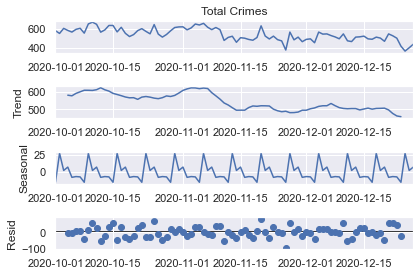

In [117]:
decomp.plot();

So we can see that there is a weekly seasonal component, but it isn't as strong as I would have imagined.  

Let's investigate these spikes a bit further.  We'll blow up just the first five years.  

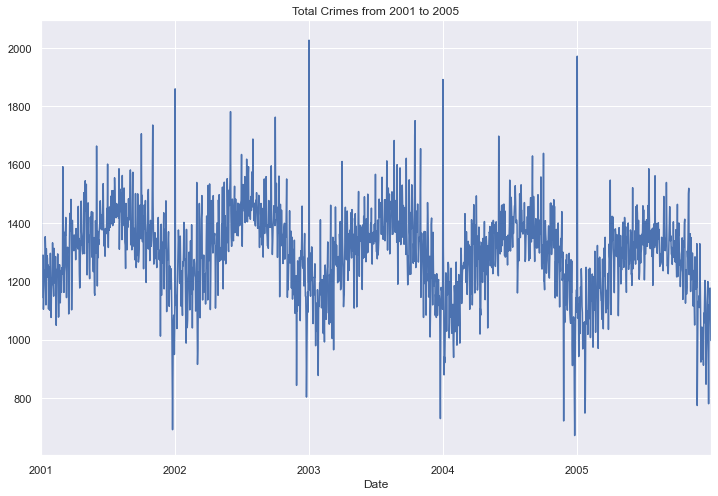

In [66]:
allcrimes_byday['Total Crimes'].loc['2001-01-01':'2005-12-31'].plot(figsize=(12,8))
plt.title('Total Crimes from 2001 to 2005');

So we see clearly that crimes are generaly higher in the summer and lower in the winter.  There also appears to be a sharp decrease right around the holidays followed by a short spike right on New Year's Day. Let's investigate this further.  

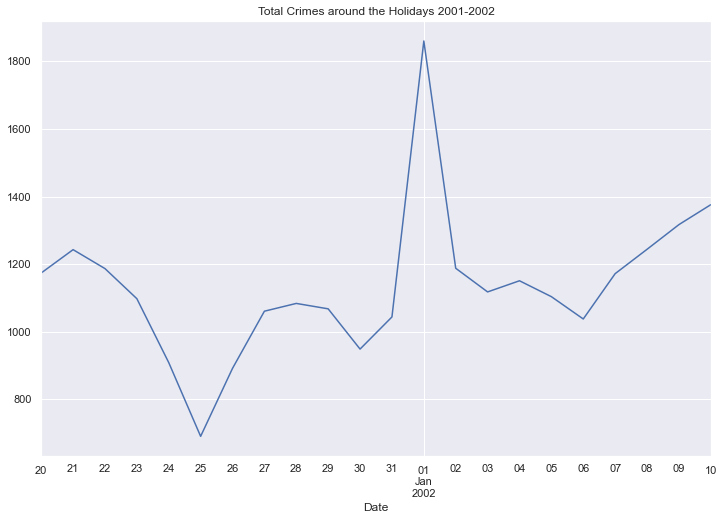

In [69]:
allcrimes_byday['Total Crimes'].loc['2001-12-20':'2002-01-10'].plot(figsize=(12,8))
plt.title('Total Crimes around the Holidays 2001-2002');

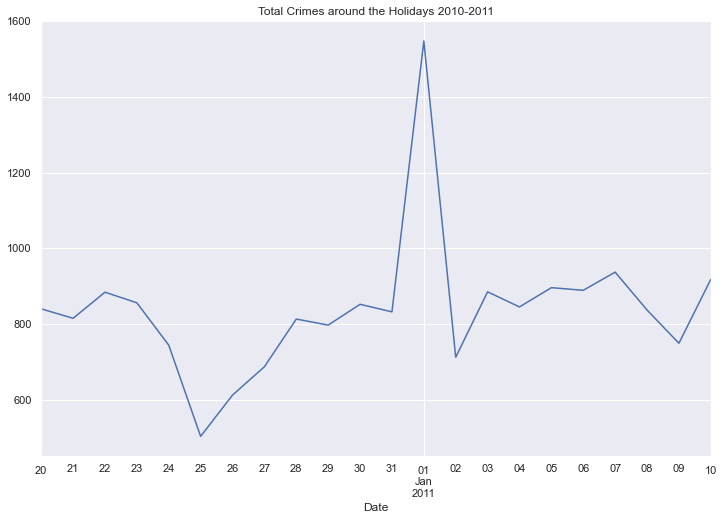

In [70]:
allcrimes_byday['Total Crimes'].loc['2010-12-20':'2011-01-10'].plot(figsize=(12,8))
plt.title('Total Crimes around the Holidays 2010-2011');

So we're definitely seeing a pattern here.  Crimes are very low on Christmas Day, then gradually increase and then there's a big spike on New Year's Day (presumably in the early morning hours).  Interesting!  

Let's also look at the big spike last summer.  

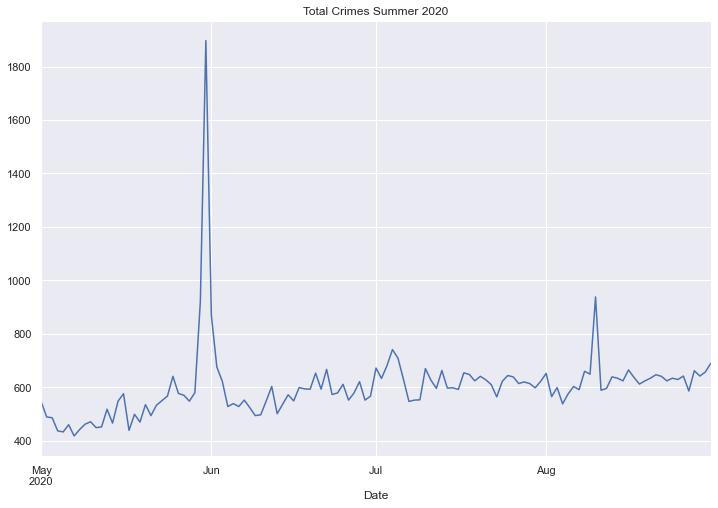

In [73]:
allcrimes_byday['Total Crimes'].loc['2020-05-01':'2020-08-31'].plot(figsize=(12,8))
plt.title('Total Crimes Summer 2020');

I've researched the dates of the looting in Chicago.  June 1st as well as August 9th and 10th were very violent days, so this corresponds to what we're seeing. 

## Holt-Winters Model

We'll split the data into 19 years of training data and 1 year of test data.

In [130]:
train = allcrimes_byday['Total Crimes'].loc['2001-01-01':'2020-01-01']
test = allcrimes_byday['Total Crimes'].loc['2020-01-01':]

In [131]:
import warnings
warnings.filterwarnings("ignore")

In [132]:
HW_model = ExponentialSmoothing(train,trend='add',seasonal='add',seasonal_periods=365).fit()

In [133]:
start=len(train)
end=len(train)+len(test)-1
HW_preds = HW_model.predict(start=start, end=end).rename('HW Predictions')

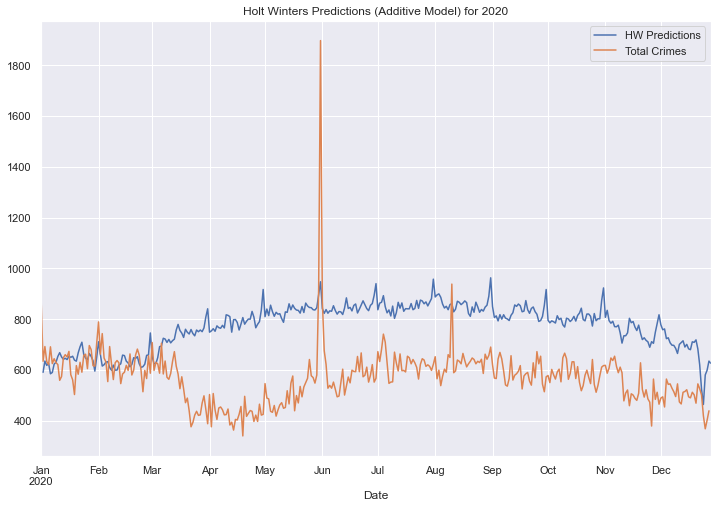

In [134]:
HW_preds.plot(figsize=(12,8),legend=True)
test.plot(legend=True);
plt.title('Holt Winters Predictions (Additive Model) for 2020');

The model predicts the data quite well for 2020 until early March, which is when the shut-downs for the pandemic started. Then throughout the remainder for 2020 crime must have been down due to the pandemic and social distancing (restaurants and stores being closed), aside from the peak in June and August during the violent protests.  

In [135]:
mae = mean_absolute_error(test, HW_preds)
print(f'MAE Error: {mae:11.10}')
rmse = np.sqrt(mean_squared_error(test, HW_preds))
print(f'RMSE Error: {rmse:11.10}')

MAE Error: 217.8056131
RMSE Error: 247.0102259


In [136]:
allcrimes_byday['Total Crimes'].describe()

count    7301.000000
mean      993.832078
std       274.736279
min       320.000000
25%       761.000000
50%       973.000000
75%      1235.000000
max      2027.000000
Name: Total Crimes, dtype: float64

So the MAE and RMSE are slightly less than the standard error, which isn't great but not unexpected due to the impact of the pandemic.  You can also see that the model is not capturing the shock to the system on June 1st (we wouldn't expect it to).  

Let's try to fit a multiplicative model.

In [138]:
HW_model = ExponentialSmoothing(train,trend='mul',seasonal='mul',seasonal_periods=365).fit()

In [139]:
start=len(train)
end=len(train)+len(test)-1
HW_preds = HW_model.predict(start=start, end=end).rename('HW Predictions')

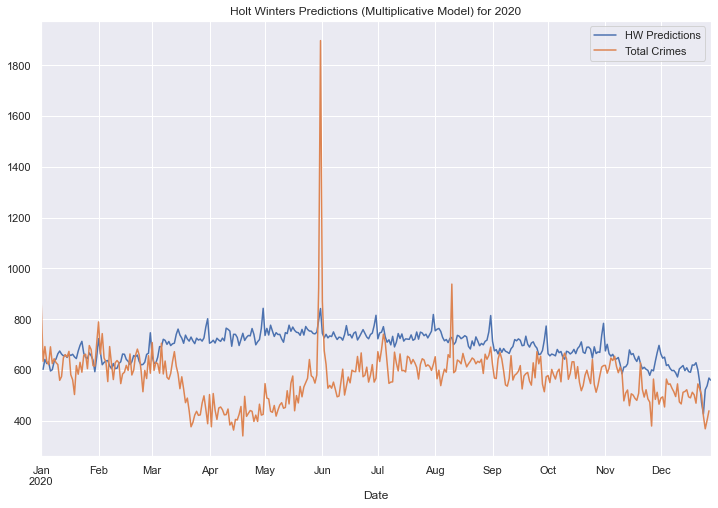

In [140]:
HW_preds.plot(figsize=(12,8),legend=True)
test.plot(legend=True);
plt.title('Holt Winters Predictions (Multiplicative Model) for 2020');

In [141]:
mae = mean_absolute_error(test, HW_preds)
print(f'MAE Error: {mae:11.10}')
rmse = np.sqrt(mean_squared_error(test, HW_preds))
print(f'RMSE Error: {rmse:11.10}')

MAE Error: 137.4954644
RMSE Error: 173.7834858


So we can see that this model performed much better, even though it also diverged from the actual data when the pandemic began.  

How did the multiplicate model do for 2019?

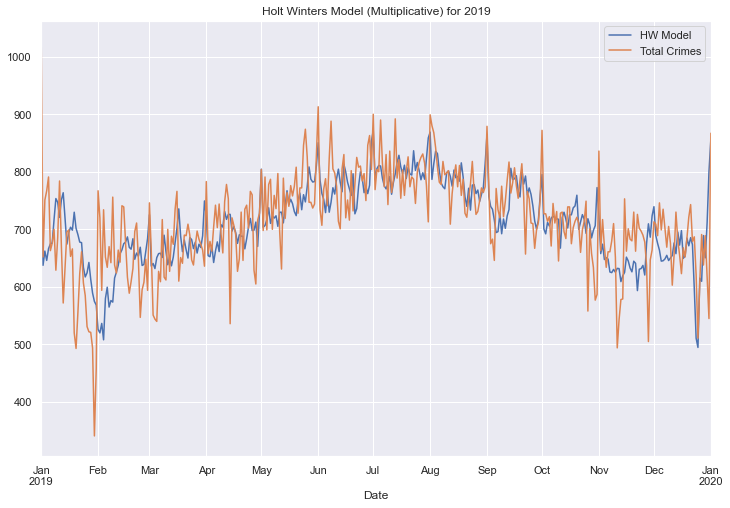

In [142]:
HW_model.fittedvalues.loc['2019-01-01':'2020-01-01'].rename('HW Model').plot(figsize=(12,8), legend=True)
train.loc['2019-01-01':'2020-01-01'].plot(legend=True)
plt.title('Holt Winters Model (Multiplicative) for 2019');

This looks quite good.  Now we can fit the model on all of the data and predict crimes for 2021.  

In [143]:
HW_model = ExponentialSmoothing(allcrimes_byday['Total Crimes'],trend='mul',seasonal='mul',seasonal_periods=365).fit()

In [145]:
start=len(allcrimes_byday['Total Crimes'])
end=len(allcrimes_byday['Total Crimes']) + 365
HW_preds = HW_model.predict(start=start, end=end).rename('HW Predictions for 2021')

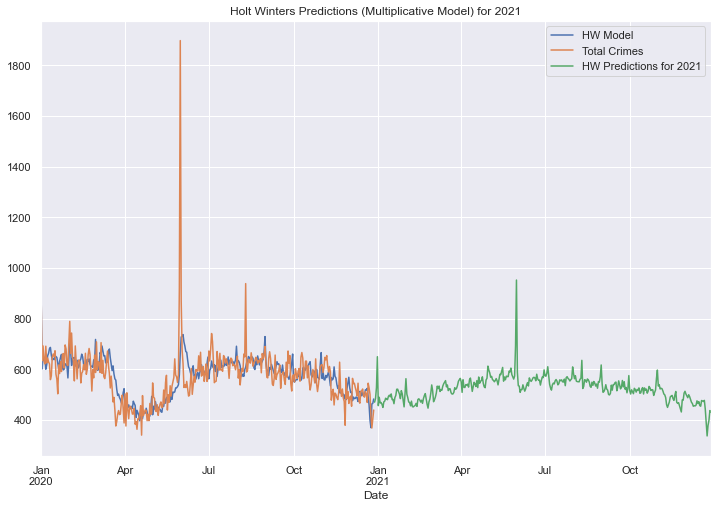

In [148]:
HW_model.fittedvalues.loc['2020-01-01':'2021-01-01'].rename('HW Model').plot(figsize=(12,8), legend=True)
allcrimes_byday['Total Crimes'].loc['2020-01-01':'2021-01-01'].plot(legend=True)
HW_preds.plot(legend=True)
plt.title('Holt Winters Predictions (Multiplicative Model) for 2021');

Our model, once fitted on all the data, follows the pattern quite well for 2020 and then predicts into 2021. Notice that while it doesn't quite capture the violent riots in June of 2020, it does predict another riot next summer! 